In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os

# Load checklist and attach species data

In [2]:
checklist_data = pickle.load(open('American_snapshot_10_10_500_each_grid.pkl','rb'))

data = checklist_data
count_columns = []
for species_file in os.listdir('./sp_count'):
    if '_2018' not in species_file:
        continue
    species_name = species_file[:-9].lower()
    species_data = pickle.load(open(os.path.join('./sp_count', species_file), 'rb'))
    species_data.rename(columns={'count': species_name}, inplace=True)
    count_columns.append(species_name)
    data = pd.merge(data, species_data, on='sampling_event_identifier', how='left')
    data[species_name][data[species_name] > 0] = 1
    data[species_name] = data[species_name].fillna(0)
data['month'] = data['observation_date'].dt.month
data['week'] = data['observation_date'].dt.isocalendar().week
print(data)


C:\Users\djl12\AppData\Local\Temp/ipykernel_3544/253062661.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[species_name][data[species_name] > 0] = 1
C:\Users\djl12\AppData\Local\Temp/ipykernel_3544/253062661.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['month'] = data['observation_date'].dt.month
C:\Users\djl12\AppData\Local\Temp/ipykernel_3544/253062661.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

       sampling_event_identifier  duration_minutes protocol_type  \
0                     S100016925             360.0     Traveling   
1                     S100016932              90.0     Traveling   
2                     S100016935             240.0     Traveling   
3                     S100016938             150.0     Traveling   
4                     S100016943              90.0     Traveling   
...                          ...               ...           ...   
487288                 S99977728              80.0     Traveling   
487289                 S99978812             180.0     Traveling   
487290                 S99979063             135.0     Traveling   
487291                 S99983654             180.0     Traveling   
487292                 S99985032             120.0     Traveling   

        effort_distance_km  number_observers time_observation_started  \
0                    3.000               5.0                 10:00:00   
1                    3.000           

# Spatial clustering and visualization

In [21]:
from ipyleaflet import Map, Circle
from ipyleaflet import Polygon as LeafletPolygon

def render_polygon_map(polygons):

    map_ = Map(zoom=2)
    map_.layout.height = '1000px'

    for cluster, polygon in polygons.items():
        poly = [_ for _ in zip(polygon.exterior.coords.xy[1], polygon.exterior.coords.xy[0])]
        point = LeafletPolygon(
            locations=poly,
            color='green'
        )
        map_.add_layer(point)

    display(map_)

In [22]:
import json

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

X = np.array([[lng, lat] for lng, lat in zip(data.longitude, data.latitude)])

clustering = DBSCAN(eps=0.25, min_samples=100).fit(X)
labels = clustering.labels_

labels

data['cluster'] = labels

polygons = {}
for group, points in data[['longitude', 'latitude', 'cluster']].groupby('cluster'):
    point_array = np.array([[lng, lat] for lng, lat in zip(points['longitude'], points['latitude'])])
    try:
        hull = ConvexHull(point_array)
        polylist = [point_array[idx] for idx in hull.vertices]
        polygons[group] = Polygon(polylist)
    except:
        pass

json_clusters = {int(cluster): [_ for _ in zip(polygon.exterior.coords.xy[1], polygon.exterior.coords.xy[0])] for cluster, polygon in polygons.items()}
with open('clusters.json', 'w') as fp:
    json.dump(json_clusters, fp, indent=2)
print(len(json_clusters))

render_polygon_map(polygons)

531


Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

# Hierarchical clustering

This first cell computes the presence of each species in each cluster during each month. It produces a dataframe where there is one row per species, and a total of columns equal to 12 times the number of regions of interest (ROIs). A 1 in the dataframe represents the species being present in that ROI in that month.

In [5]:
from sklearn.cluster import AgglomerativeClustering

clustered_data = data.groupby(['cluster', 'week']).agg(
    **{species_name: pd.NamedAgg(column=species_name, aggfunc='max') for species_name in count_columns}
).transpose()
clustered_data = clustered_data.loc[~(clustered_data==0.0).all(axis=1)]

print(clustered_data)

cluster               -1                                                 ...  \
week                    1    2    3    4    5    6    7    8    9    10  ...   
american_coot          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
american_crow          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
american_goldfinch     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
american_kestrel       1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
american_robin         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
...                    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
white_hawk             1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
white_wagtail          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
willow_warbler         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
yellow-rumped_warbler  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
zone-tailed_hawk       1.0  1.0  1.0  1.

Produces a hierarchical clustering dendrogram to show species similarity.

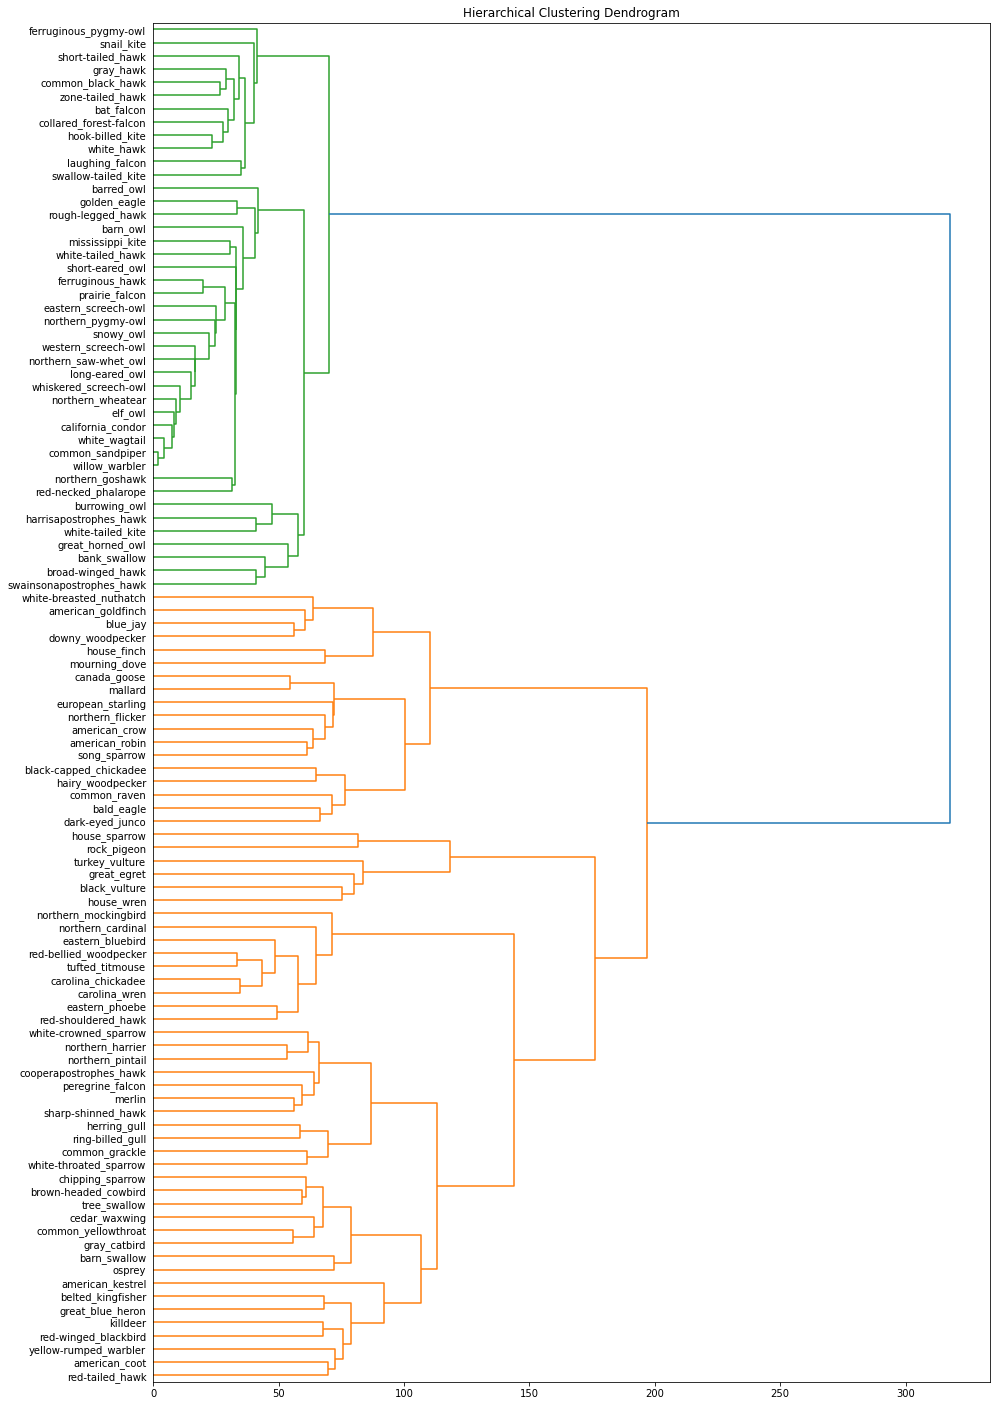

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(15, 25))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
#plot_dendrogram(model, truncate_mode="level", p=3)
dendrogram(linkage(clustered_data, method='ward'), orientation='right', distance_sort='descending', labels=list(clustered_data.index))
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
#plt.show()
plt.savefig('dendrogram.png')

# Species similarity heatmap

Produces a heatmap that shows cosine similarity between the species ROI-month vectors.

In [7]:
from scipy import spatial

species_similarity = {}
for species_1 in list(clustered_data.index):
    similarities = {}
    for species_2 in list(clustered_data.index):
        species_1_row = clustered_data.loc[[species_1]].values
        species_2_row = clustered_data.loc[[species_2]].values
        similarities[species_2] = 1 - spatial.distance.cosine(species_1_row, species_2_row)
    species_similarity[species_1] = similarities
similarity_df = pd.DataFrame(species_similarity)

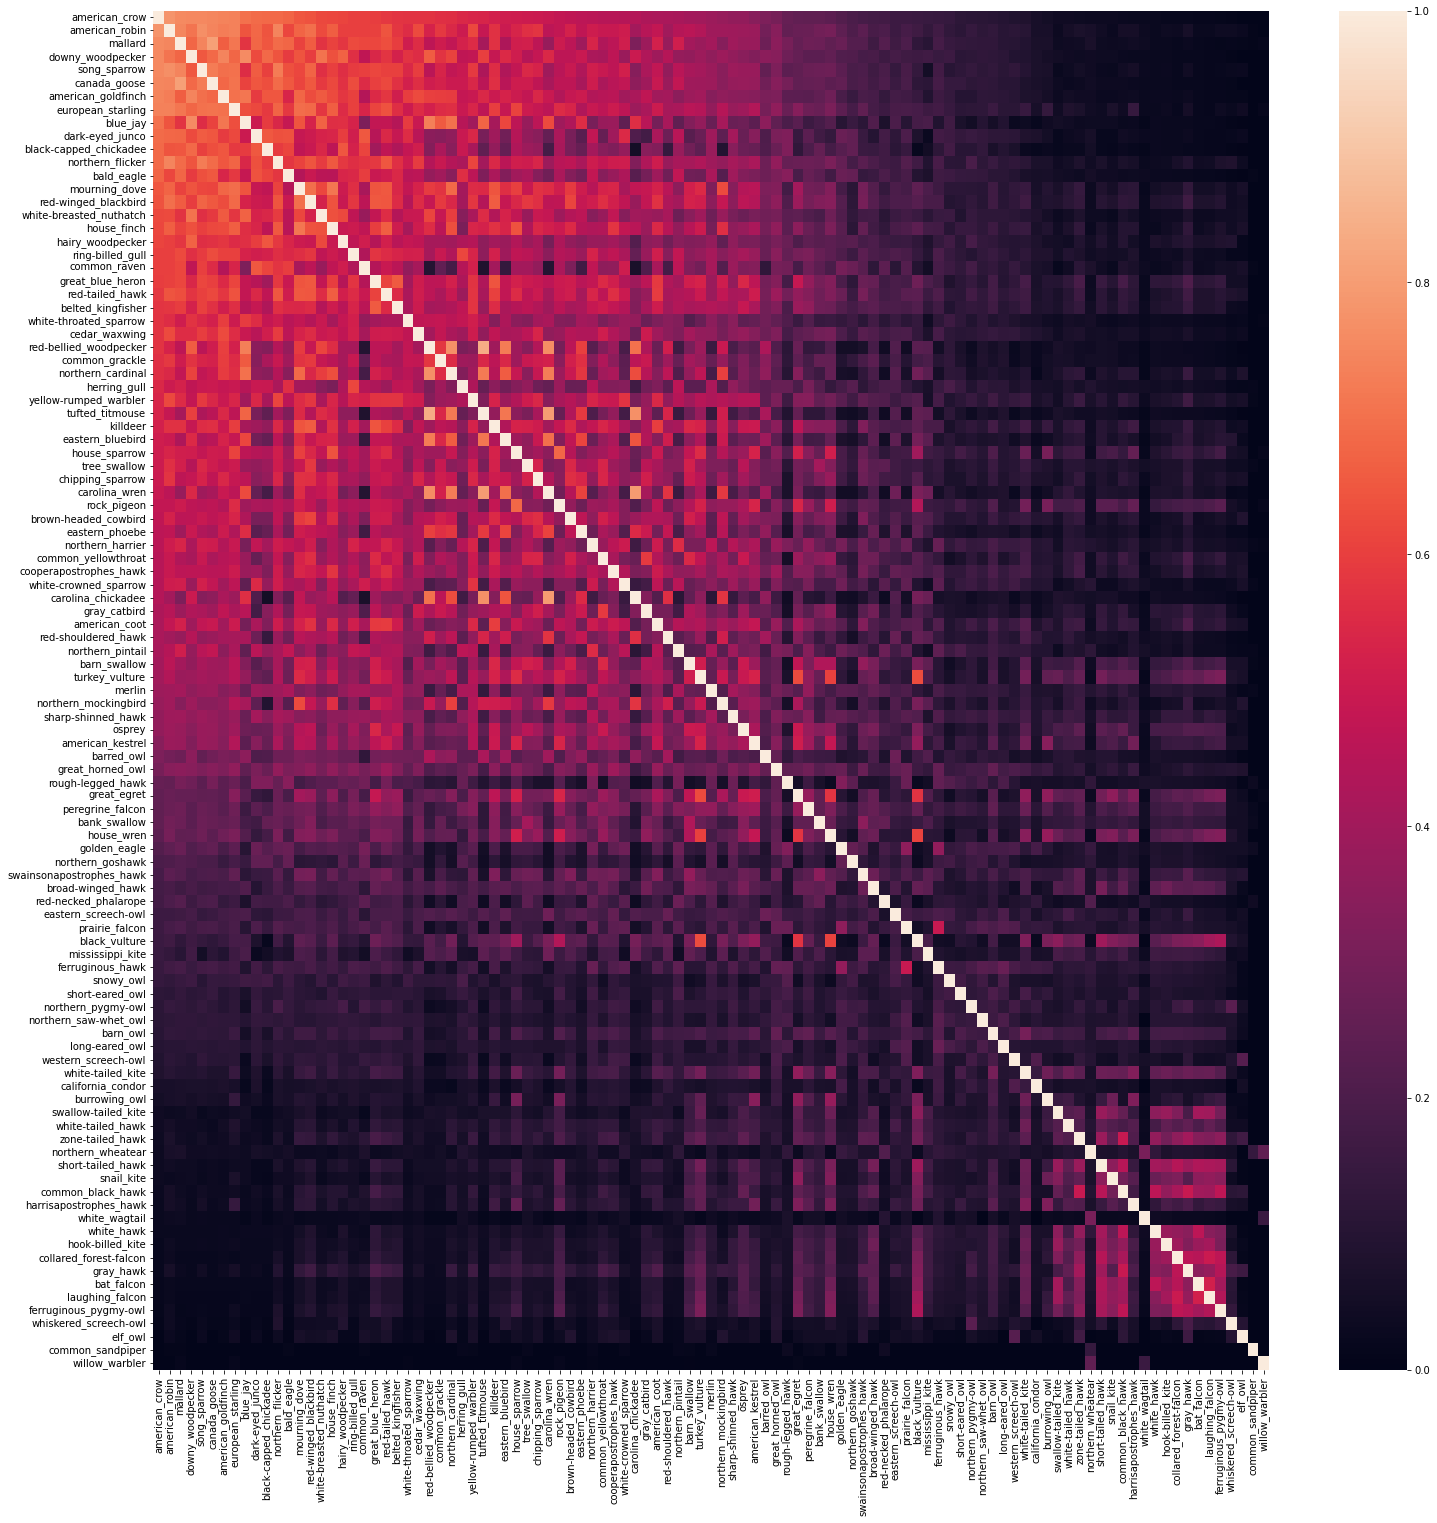

In [8]:
species_in_question = 'american_crow'
similarity_df = similarity_df.sort_values(by=species_in_question, axis=1, ascending=False).sort_values(by=species_in_question, axis=0, ascending=False)
plt.figure(figsize=(25, 25))
sns.heatmap(similarity_df)
plt.show()

# Mean, max, min lat-lng clustering

In [9]:
data['species'] = data[list(clustered_data.index)].idxmax(axis=1)
subset = data[['species', 'week', 'latitude', 'longitude']]

aggregated = []
for species, species_group in subset.groupby('species'):
    species_agg = {'species': species}
    for month, month_group in species_group.groupby('week'):
        species_agg[f'{month}_latitude_mean'] = month_group.latitude.mean()
        species_agg[f'{month}_longitude_mean'] = month_group.longitude.mean()
        species_agg[f'{month}_latitude_max'] = month_group.latitude.max()
        species_agg[f'{month}_longitude_max'] = month_group.longitude.max()
        species_agg[f'{month}_latitude_min'] = month_group.latitude.min()
        species_agg[f'{month}_longitude_min'] = month_group.longitude.min()
    aggregated.append(species_agg)
aggregated = pd.DataFrame(aggregated).set_index('species').fillna(0)
aggregated

,1_latitude_mean,1_longitude_mean,1_latitude_max,1_longitude_max,1_latitude_min,1_longitude_min,2_latitude_mean,2_longitude_mean,2_latitude_max,2_longitude_max,...,51_latitude_max,51_longitude_max,51_latitude_min,51_longitude_min,52_latitude_mean,52_longitude_mean,52_latitude_max,52_longitude_max,52_latitude_min,52_longitude_min
species,,,,,,,,,,,,,,,,,,,,,
american_coot,19.434996,-93.803165,60.089142,-35.216329,-64.895556,-159.767953,6.457664,-86.879066,59.652185,-35.943532,...,57.832689,-35.591467,-65.174860,-160.094705,6.385848,-88.069664,58.130030,-35.943532,-64.823889,-159.767953
american_crow,40.912135,-92.750338,60.579324,-52.624685,25.136660,-151.543600,42.427520,-90.305726,60.542843,-52.624685,...,60.542298,-52.669723,25.389338,-151.716042,41.992891,-91.486286,60.562745,-52.659981,25.187697,-153.330864
american_goldfinch,39.456589,-90.110806,53.909799,-52.696741,26.124386,-124.106381,39.704430,-90.547974,50.374322,-52.731699,...,53.256088,-52.911202,25.281305,-124.014510,40.340760,-91.498981,53.256088,-52.696741,26.081300,-123.111289
american_kestrel,19.877787,-91.979552,49.538696,-40.025106,-53.182591,-124.275224,9.453840,-84.657199,50.353583,-43.034543,...,50.634441,-37.402486,-51.533149,-124.371371,10.890304,-85.362647,50.326361,-47.839994,-54.933183,-123.433572
american_robin,39.302077,-101.482768,61.207694,-57.712169,17.641126,-151.413101,37.985210,-99.491801,61.190013,-52.791806,...,62.444987,-71.147997,19.149845,-152.359341,39.523034,-103.778220,64.789467,-52.624685,17.044062,-147.968218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
white-throated_sparrow,37.087253,-122.082972,37.087253,-122.082972,37.087253,-122.082972,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
white_hawk,5.140937,-73.980078,18.423550,-59.770305,-2.448913,-94.950050,6.057661,-65.021590,10.740392,-58.910065,...,9.497801,-60.080730,-2.552963,-79.660184,2.598805,-79.340554,16.598030,-67.908803,-14.162419,-88.567314
white_wagtail,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


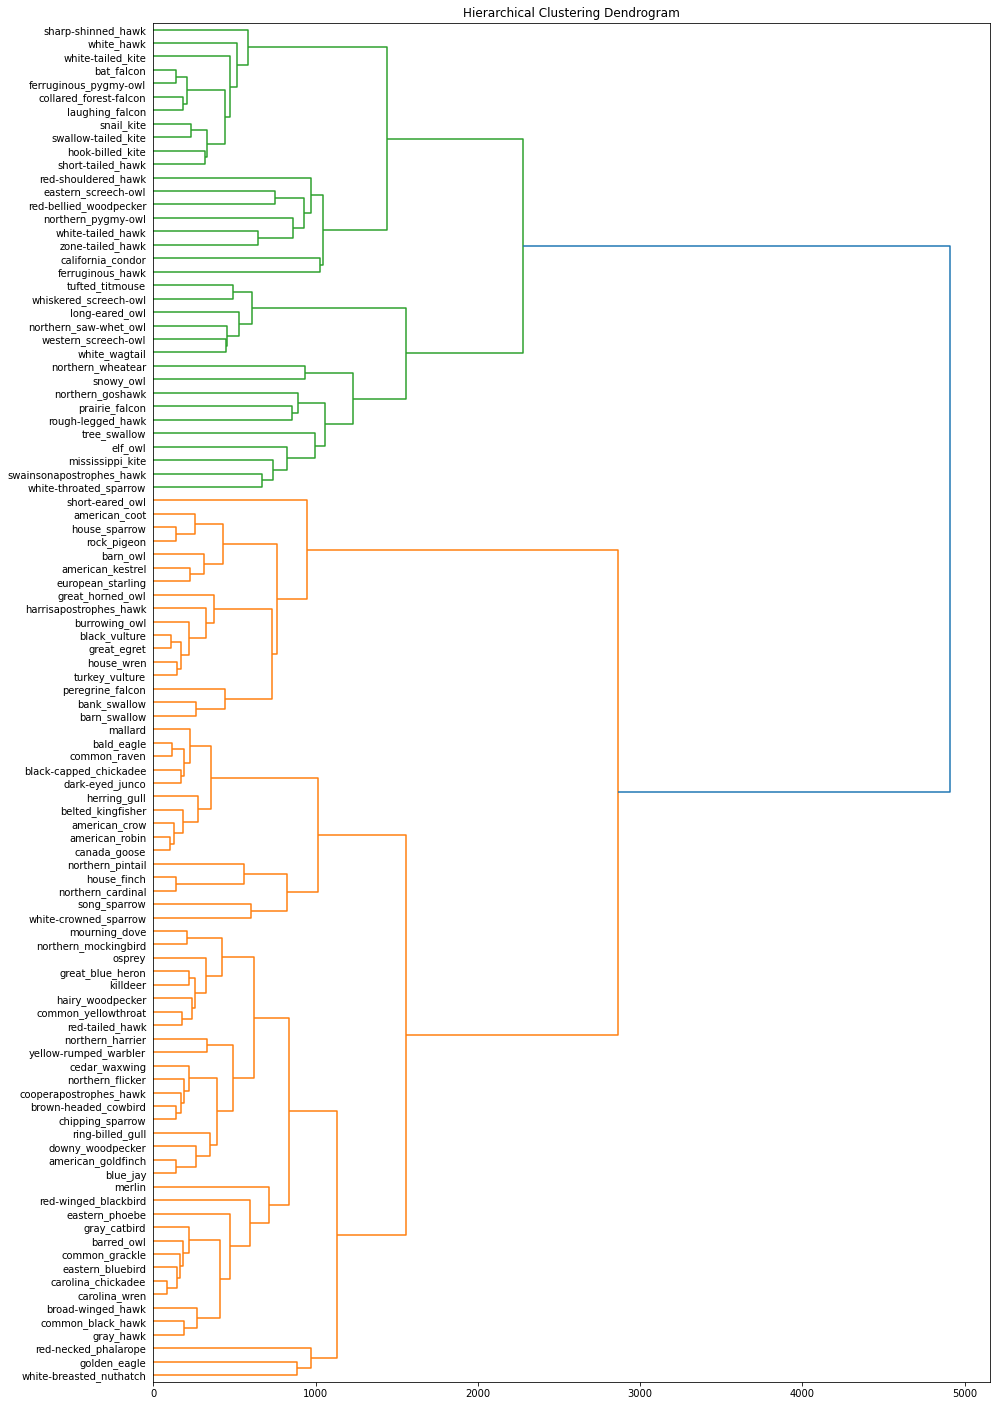

In [10]:
plt.figure(figsize=(15, 25))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
#plot_dendrogram(model, truncate_mode="level", p=3)
dendrogram(linkage(aggregated, method='ward'), orientation='right', distance_sort='descending', labels=list(aggregated.index))
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
#plt.show()
plt.savefig('dendrogram_baseline.png')

# Mean, max, min lat-lng Similarity Heatmap

In [11]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians

def average_haversine_distance(row1, row2):
    total = 0
    for month in range(1, 53):
        point1 = [radians(_) for _ in [row1[f'{month}_longitude_mean'], row1[f'{month}_latitude_mean']]]
        point2 = [radians(_) for _ in [row2[f'{month}_longitude_mean'], row2[f'{month}_latitude_mean']]]
        total += haversine_distances([point1, point2])[0][1] * 6371000 / 1000
    return total / 52

species_distances = {}
for species_1 in list(aggregated.index):
    distances = {}
    for species_2 in list(aggregated.index):
        species_1_row = aggregated.loc[[species_1]]
        species_2_row = aggregated.loc[[species_2]]
        distances[species_2] = average_haversine_distance(species_1_row, species_2_row)
    species_distances[species_1] = distances
distance_df = pd.DataFrame(species_distances)

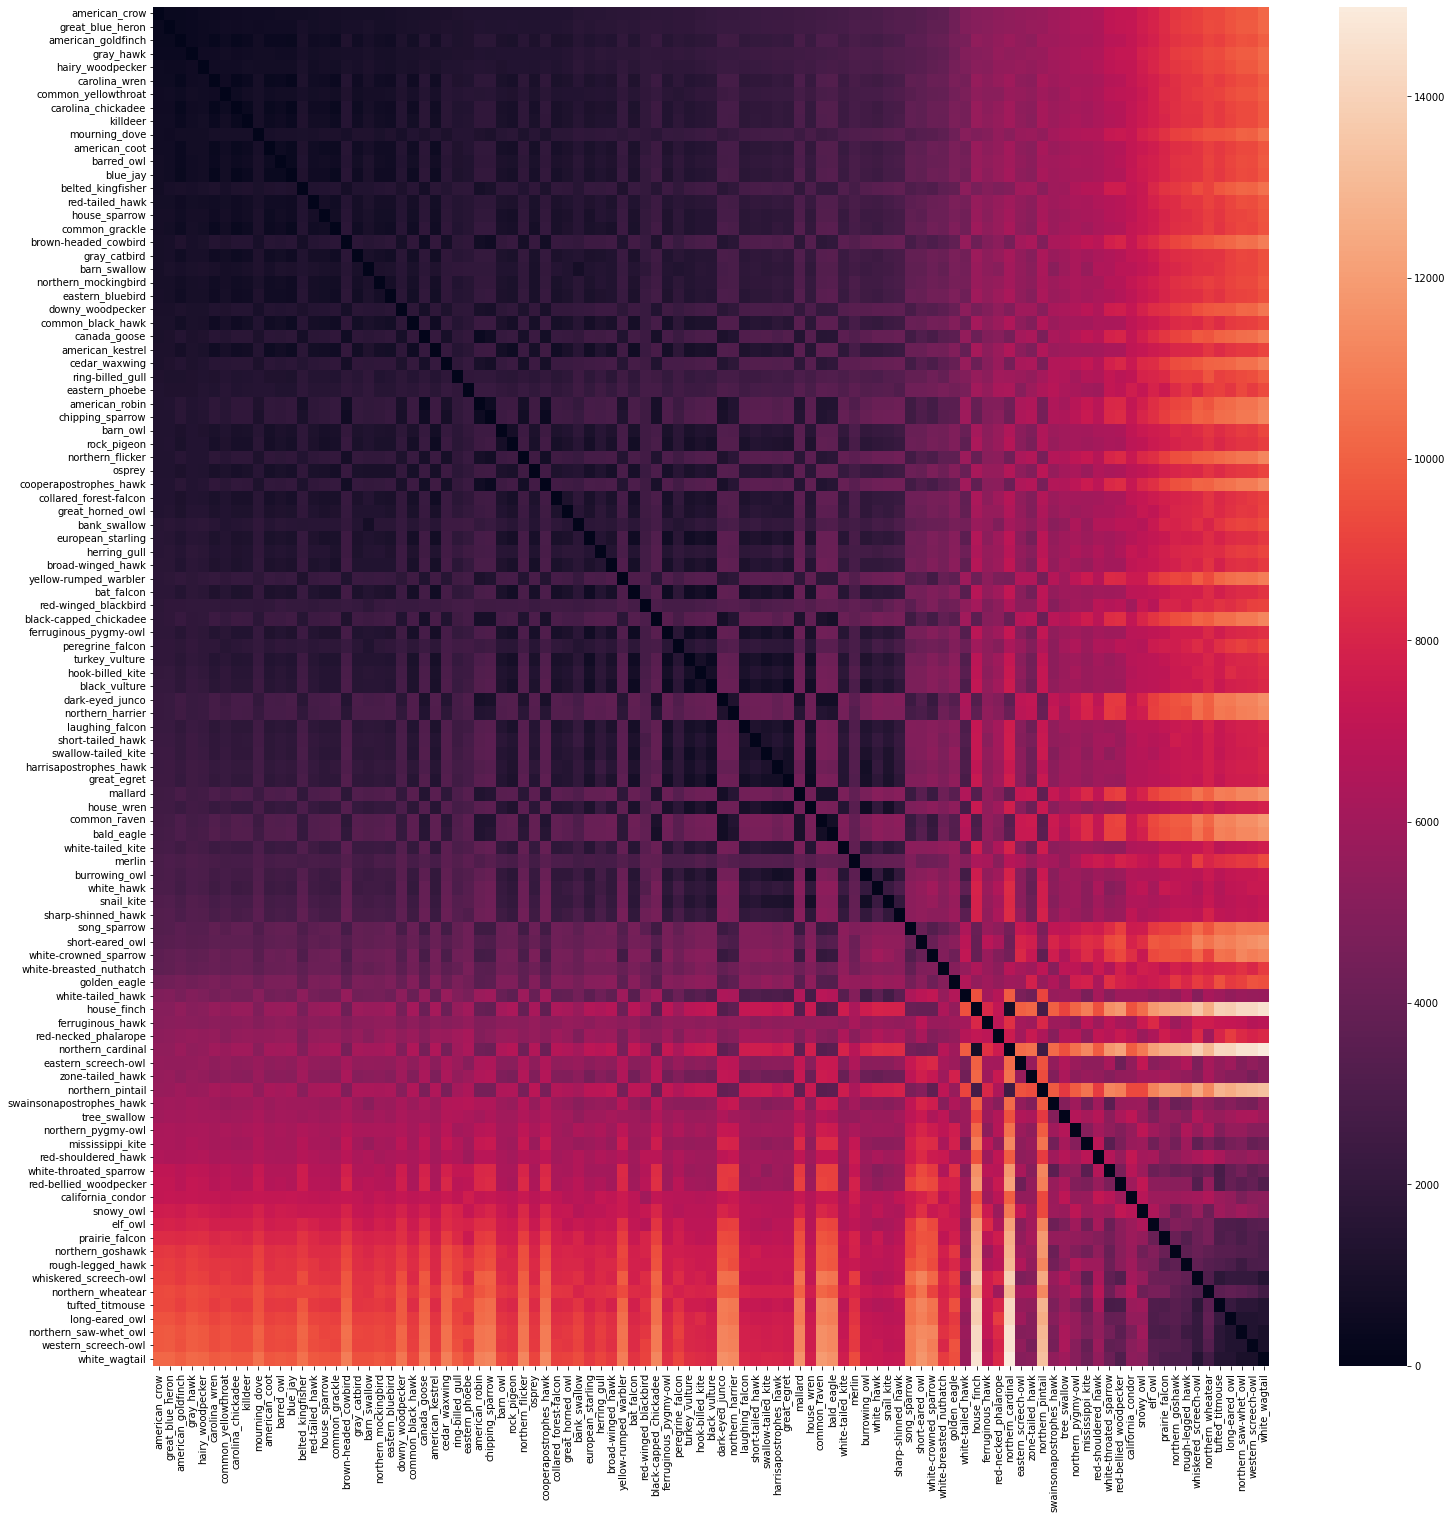

In [12]:
species_in_question = 'american_crow'
distance_df = distance_df.sort_values(by=species_in_question, axis=1, ascending=True).sort_values(by=species_in_question, axis=0, ascending=True)
plt.figure(figsize=(25, 25))
sns.heatmap(distance_df)
plt.show()

# Load Taxonomy

In [13]:
taxonomy = pd.read_csv('./taxonomy.csv')
taxonomy = taxonomy.dropna(subset=['PRIMARY_COM_NAME'])

taxonomy['PRIMARY_COM_NAME'] = taxonomy['PRIMARY_COM_NAME'].apply(lambda x: x.lower().replace(' ', '_'))
taxonomy = taxonomy[['PRIMARY_COM_NAME', 'Trophic.Level', 'Family1', 'Order1', 'Trophic.Niche', 'Primary.Lifestyle']].set_index('PRIMARY_COM_NAME')
print(taxonomy['Trophic.Level'].unique())
print(taxonomy['Family1'].unique())
print(taxonomy['Order1'].unique())
print(taxonomy['Trophic.Niche'].unique())
print(taxonomy['Primary.Lifestyle'].unique())
taxonomy['Simplified.Trophic.Level'] = taxonomy['Trophic.Level'].apply(lambda x: 'Non-Predator' if x in ['Omnivore', 'Herbivore'] else 'Predator')
print(taxonomy)

['Carnivore' 'Omnivore' 'Herbivore' 'Scavenger' nan]
['Motacillidae' 'Pandionidae' 'Passerellidae' 'Paridae' 'Cathartidae'
 'Strigidae' 'Corvidae' 'Bombycillidae' 'Falconidae' 'Icteridae'
 'Tyrannidae' 'Laridae' 'Accipitridae' 'Columbidae' 'Scolopacidae'
 'Parulidae' 'Anatidae' 'Picidae' 'Glareolidae' 'Rallidae' 'Troglodytidae'
 'Caprimulgidae' 'Ardeidae' 'Turdidae' 'Hirundinidae' 'Muscicapidae'
 'Sittidae' 'Passeridae' 'Fringillidae' 'Haematopodidae' 'Mimidae'
 'Cardinalidae' 'Phylloscopidae' 'Tytonidae' 'Acrocephalidae' nan
 'Charadriidae' 'Sturnidae' 'Alcedinidae']
['Passeriformes' 'Accipitriformes' 'Cathartiformes' 'Strigiformes'
 'Falconiformes' 'Charadriiformes' 'Columbiformes' 'Anseriformes'
 'Piciformes' 'Gruiformes' 'Caprimulgiformes' 'Pelecaniformes' nan
 'Coraciiformes']
['Invertivore' 'Aquatic predator' 'Omnivore' 'Scavenger' 'Vertivore'
 'Frugivore' 'Granivore' 'Herbivore terrestrial' 'Herbivore aquatic' nan]
['Terrestrial' 'Aerial' 'Generalist' 'Insessorial' 'Aquatic' nan

# Kmeans - Trophic Level

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score

clustering_scores = []

# ROI clustering
roi_kmeans = KMeans(n_clusters=len(taxonomy['Simplified.Trophic.Level'].unique())).fit(clustered_data)
roi_preds = pd.DataFrame({'species': clustered_data.index, 'cluster': roi_kmeans.labels_}).set_index('species').merge(taxonomy, how='left', left_index=True, right_index=True).dropna()
print(adjusted_mutual_info_score(labels_true=roi_preds['Simplified.Trophic.Level'], labels_pred=roi_preds['cluster']))
clustering_scores.append({
    'Spatio-temporal Aggregation Method': 'Region-of-Interest',
    'Clustering Method': 'K-means',
    'Taxonomy Category': 'Trophic',
    'Number of Clusters': roi_kmeans.n_clusters,
    'Adjusted Mutual Information Score': adjusted_mutual_info_score(labels_true=roi_preds['Simplified.Trophic.Level'], labels_pred=roi_preds['cluster'])
})

# geographic clustering
geographic_kmeans = KMeans(n_clusters=len(taxonomy['Simplified.Trophic.Level'].unique())).fit(aggregated)
geographic_preds = pd.DataFrame({'species': aggregated.index, 'cluster': geographic_kmeans.labels_}).set_index('species').merge(taxonomy, how='left', left_index=True, right_index=True).dropna()
print(adjusted_mutual_info_score(labels_true=geographic_preds['Simplified.Trophic.Level'], labels_pred=geographic_preds['cluster']))
clustering_scores.append({
    'Spatio-temporal Aggregation Method': 'Summary Statistics',
    'Clustering Method': 'K-means',
    'Taxonomy Category': 'Trophic',
    'Number of Clusters': geographic_kmeans.n_clusters,
    'Adjusted Mutual Information Score': adjusted_mutual_info_score(labels_true=geographic_preds['Simplified.Trophic.Level'], labels_pred=geographic_preds['cluster'])
})

C:\Users\djl12\anaconda3\envs\mads\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


0.20086707230130155
0.09047127794125424


# Hierarchical - Trophic Level

In [15]:
from sklearn.cluster import AgglomerativeClustering

# ROI clustering
roi_agglomerative = AgglomerativeClustering(n_clusters=len(taxonomy['Simplified.Trophic.Level'].unique())).fit(clustered_data)
roi_preds = pd.DataFrame({'species': clustered_data.index, 'cluster': roi_agglomerative.labels_}).set_index('species').merge(taxonomy, how='left', left_index=True, right_index=True).dropna()
print(adjusted_mutual_info_score(labels_true=roi_preds['Simplified.Trophic.Level'], labels_pred=roi_preds['cluster']))
clustering_scores.append({
    'Spatio-temporal Aggregation Method': 'Region-of-Interest',
    'Clustering Method': 'Agglomerative',
    'Taxonomy Category': 'Trophic',
    'Number of Clusters': roi_agglomerative.n_clusters,
    'Adjusted Mutual Information Score': adjusted_mutual_info_score(labels_true=roi_preds['Simplified.Trophic.Level'], labels_pred=roi_preds['cluster'])
})

# geographic clustering
geographic_agglomerative = AgglomerativeClustering(n_clusters=len(taxonomy['Simplified.Trophic.Level'].unique())).fit(aggregated)
geographic_preds = pd.DataFrame({'species': aggregated.index, 'cluster': geographic_agglomerative.labels_}).set_index('species').merge(taxonomy, how='left', left_index=True, right_index=True).dropna()
print(adjusted_mutual_info_score(labels_true=geographic_preds['Simplified.Trophic.Level'], labels_pred=geographic_preds['cluster']))
clustering_scores.append({
    'Spatio-temporal Aggregation Method': 'Summary Statistics',
    'Clustering Method': 'Agglomerative',
    'Taxonomy Category': 'Trophic',
    'Number of Clusters': geographic_agglomerative.n_clusters,
    'Adjusted Mutual Information Score': adjusted_mutual_info_score(labels_true=geographic_preds['Simplified.Trophic.Level'], labels_pred=geographic_preds['cluster'])
})


0.30407887094748787
0.1327127528644853


C:\Users\djl12\anaconda3\envs\mads\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


# Kmeans - Order

In [16]:
# ROI clustering
roi_kmeans = KMeans(n_clusters=len(taxonomy['Order1'].unique())).fit(clustered_data)
roi_preds = pd.DataFrame({'species': clustered_data.index, 'cluster': roi_kmeans.labels_}).set_index('species').merge(taxonomy, how='left', left_index=True, right_index=True).dropna()
print(adjusted_mutual_info_score(labels_true=roi_preds['Order1'], labels_pred=roi_preds['cluster']))
clustering_scores.append({
    'Spatio-temporal Aggregation Method': 'Region-of-Interest',
    'Clustering Method': 'K-means',
    'Taxonomy Category': 'Order',
    'Number of Clusters': roi_kmeans.n_clusters,
    'Adjusted Mutual Information Score': adjusted_mutual_info_score(labels_true=roi_preds['Order1'], labels_pred=roi_preds['cluster'])
})

# geographic clustering
geographic_kmeans = KMeans(n_clusters=len(taxonomy['Order1'].unique())).fit(aggregated)
geographic_preds = pd.DataFrame({'species': aggregated.index, 'cluster': geographic_kmeans.labels_}).set_index('species').merge(taxonomy, how='left', left_index=True, right_index=True).dropna()
print(adjusted_mutual_info_score(labels_true=geographic_preds['Order1'], labels_pred=geographic_preds['cluster']))
clustering_scores.append({
    'Spatio-temporal Aggregation Method': 'Summary Statistics',
    'Clustering Method': 'K-means',
    'Taxonomy Category': 'Order',
    'Number of Clusters': geographic_kmeans.n_clusters,
    'Adjusted Mutual Information Score': adjusted_mutual_info_score(labels_true=geographic_preds['Order1'], labels_pred=geographic_preds['cluster'])
})

C:\Users\djl12\anaconda3\envs\mads\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


0.19738115843170234
0.1318025788406283


# Hierarchical - Order

In [17]:
# ROI clustering
roi_agglomerative = AgglomerativeClustering(n_clusters=len(taxonomy['Order1'].unique())).fit(clustered_data)
roi_preds = pd.DataFrame({'species': clustered_data.index, 'cluster': roi_agglomerative.labels_}).set_index('species').merge(taxonomy, how='left', left_index=True, right_index=True).dropna()
print(adjusted_mutual_info_score(labels_true=roi_preds['Order1'], labels_pred=roi_preds['cluster']))
clustering_scores.append({
    'Spatio-temporal Aggregation Method': 'Region-of-Interest',
    'Clustering Method': 'Agglomerative',
    'Taxonomy Category': 'Order',
    'Number of Clusters': roi_agglomerative.n_clusters,
    'Adjusted Mutual Information Score': adjusted_mutual_info_score(labels_true=roi_preds['Order1'], labels_pred=roi_preds['cluster'])
})

# geographic clustering
geographic_agglomerative = AgglomerativeClustering(n_clusters=len(taxonomy['Order1'].unique())).fit(aggregated)
geographic_preds = pd.DataFrame({'species': aggregated.index, 'cluster': geographic_agglomerative.labels_}).set_index('species').merge(taxonomy, how='left', left_index=True, right_index=True).dropna()
print(adjusted_mutual_info_score(labels_true=geographic_preds['Order1'], labels_pred=geographic_preds['cluster']))
clustering_scores.append({
    'Spatio-temporal Aggregation Method': 'Summary Statistics',
    'Clustering Method': 'Agglomerative',
    'Taxonomy Category': 'Order',
    'Number of Clusters': geographic_agglomerative.n_clusters,
    'Adjusted Mutual Information Score': adjusted_mutual_info_score(labels_true=geographic_preds['Order1'], labels_pred=geographic_preds['cluster'])
})

C:\Users\djl12\anaconda3\envs\mads\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


0.20900001102960708
0.11984683095241357


In [18]:
# ROI clustering
roi_kmeans = KMeans(n_clusters=len(taxonomy['Family1'].unique())).fit(clustered_data)
roi_preds = pd.DataFrame({'species': clustered_data.index, 'cluster': roi_kmeans.labels_}).set_index('species').merge(taxonomy, how='left', left_index=True, right_index=True).dropna()
print(adjusted_mutual_info_score(labels_true=roi_preds['Family1'], labels_pred=roi_preds['cluster']))
clustering_scores.append({
    'Spatio-temporal Aggregation Method': 'Region-of-Interest',
    'Clustering Method': 'K-means',
    'Taxonomy Category': 'Family',
    'Number of Clusters': roi_kmeans.n_clusters,
    'Adjusted Mutual Information Score': adjusted_mutual_info_score(labels_true=roi_preds['Family1'], labels_pred=roi_preds['cluster'])
})

# geographic clustering
geographic_kmeans = KMeans(n_clusters=len(taxonomy['Family1'].unique())).fit(aggregated)
geographic_preds = pd.DataFrame({'species': aggregated.index, 'cluster': geographic_kmeans.labels_}).set_index('species').merge(taxonomy, how='left', left_index=True, right_index=True).dropna()
print(adjusted_mutual_info_score(labels_true=geographic_preds['Family1'], labels_pred=geographic_preds['cluster']))
clustering_scores.append({
    'Spatio-temporal Aggregation Method': 'Summary Statistics',
    'Clustering Method': 'K-means',
    'Taxonomy Category': 'Family',
    'Number of Clusters': geographic_kmeans.n_clusters,
    'Adjusted Mutual Information Score': adjusted_mutual_info_score(labels_true=geographic_preds['Family1'], labels_pred=geographic_preds['cluster'])
})

C:\Users\djl12\anaconda3\envs\mads\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


0.3331662379517454
0.0999796959637798


In [19]:
# ROI clustering
roi_agglomerative = AgglomerativeClustering(n_clusters=len(taxonomy['Family1'].unique())).fit(clustered_data)
roi_preds = pd.DataFrame({'species': clustered_data.index, 'cluster': roi_agglomerative.labels_}).set_index('species').merge(taxonomy, how='left', left_index=True, right_index=True).dropna()
print(adjusted_mutual_info_score(labels_true=roi_preds['Family1'], labels_pred=roi_preds['cluster']))
clustering_scores.append({
    'Spatio-temporal Aggregation Method': 'Region-of-Interest',
    'Clustering Method': 'Agglomerative',
    'Taxonomy Category': 'Family',
    'Number of Clusters': roi_agglomerative.n_clusters,
    'Adjusted Mutual Information Score': adjusted_mutual_info_score(labels_true=roi_preds['Family1'], labels_pred=roi_preds['cluster'])
})

# geographic clustering
geographic_agglomerative = AgglomerativeClustering(n_clusters=len(taxonomy['Family1'].unique())).fit(aggregated)
geographic_preds = pd.DataFrame({'species': aggregated.index, 'cluster': geographic_agglomerative.labels_}).set_index('species').merge(taxonomy, how='left', left_index=True, right_index=True).dropna()
print(adjusted_mutual_info_score(labels_true=geographic_preds['Family1'], labels_pred=geographic_preds['cluster']))
clustering_scores.append({
    'Spatio-temporal Aggregation Method': 'Summary Statistics',
    'Clustering Method': 'Agglomerative',
    'Taxonomy Category': 'Family',
    'Number of Clusters': geographic_agglomerative.n_clusters,
    'Adjusted Mutual Information Score': adjusted_mutual_info_score(labels_true=geographic_preds['Family1'], labels_pred=geographic_preds['cluster'])
})

0.31926026238377453


C:\Users\djl12\anaconda3\envs\mads\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


0.06646912986912913


# Clustering Quality Visualization

   Spatio-temporal Aggregation Method Clustering Method Taxonomy Category  \
0                  Region-of-Interest           K-means           Trophic   
1                  Summary Statistics           K-means           Trophic   
2                  Region-of-Interest     Agglomerative           Trophic   
3                  Summary Statistics     Agglomerative           Trophic   
4                  Region-of-Interest           K-means             Order   
5                  Summary Statistics           K-means             Order   
6                  Region-of-Interest     Agglomerative             Order   
7                  Summary Statistics     Agglomerative             Order   
8                  Region-of-Interest           K-means            Family   
9                  Summary Statistics           K-means            Family   
10                 Region-of-Interest     Agglomerative            Family   
11                 Summary Statistics     Agglomerative            Family   

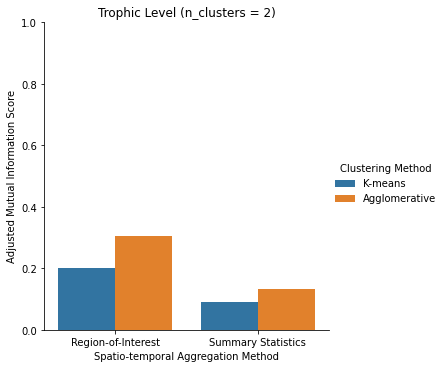

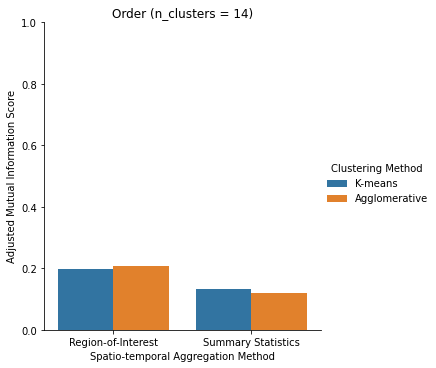

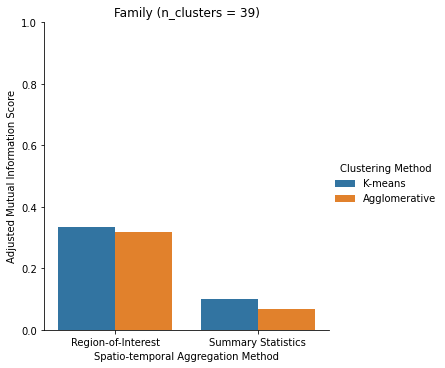

In [20]:
import matplotlib.pyplot as plt

clustering_stats = pd.DataFrame(clustering_scores)
print(clustering_stats)

trophic = clustering_stats[clustering_stats['Taxonomy Category'] == 'Trophic']
order = clustering_stats[clustering_stats['Taxonomy Category'] == 'Order']
family = clustering_stats[clustering_stats['Taxonomy Category'] == 'Family']


sns.catplot(data=trophic, kind='bar', x='Spatio-temporal Aggregation Method', y='Adjusted Mutual Information Score', hue='Clustering Method').set(title='Trophic Level (n_clusters = 2)', ylim=[0, 1]).savefig('clustering_trophic.png', transparent=True)
sns.catplot(data=order, kind='bar', x='Spatio-temporal Aggregation Method', y='Adjusted Mutual Information Score', hue='Clustering Method').set(title='Order (n_clusters = 14)', ylim=[0, 1]).savefig('clustering_order.png', transparent=True)
sns.catplot(data=family, kind='bar', x='Spatio-temporal Aggregation Method', y='Adjusted Mutual Information Score', hue='Clustering Method').set(title='Family (n_clusters = 39)', ylim=[0, 1]).savefig('clustering_family.png', transparent=True)

# Sensitivity analysis

In [28]:
outputs = []
parameter_sets = [
    {'time': 'week', 'space': {'min_samples': 25}},
    {'time': 'week', 'space': {'min_samples': 100}},
    {'time': 'month', 'space': {'min_samples': 25}},
    {'time': 'month', 'space': {'min_samples': 100}}
]

X = np.array([[lng, lat] for lng, lat in zip(data.longitude, data.latitude)])

for parameters in parameter_sets:
    clustering = DBSCAN(eps=0.25, **parameters['space']).fit(X)
    labels = clustering.labels_
    data['cluster'] = labels

    clustered_data = data.groupby(['cluster', parameters['time']]).agg(
        **{species_name: pd.NamedAgg(column=species_name, aggfunc='max') for species_name in count_columns}
    ).transpose()
    clustered_data = clustered_data.loc[~(clustered_data==0.0).all(axis=1)]

    roi_kmeans = AgglomerativeClustering(n_clusters=len(taxonomy['Family1'].unique())).fit(clustered_data)
    roi_preds = pd.DataFrame({'species': clustered_data.index, 'cluster': roi_kmeans.labels_}).set_index('species').merge(taxonomy, how='left', left_index=True, right_index=True).dropna()

    outputs.append({
        'min_samples': parameters['space']['min_samples'],
        'rois': len(set(labels)) - (1 if -1 in labels else 0),
        'time': parameters['time'],
        'score': adjusted_mutual_info_score(labels_true=roi_preds['Family1'], labels_pred=roi_preds['cluster'])
    })

outputs = pd.DataFrame(outputs)
print(outputs)


C:\Users\djl12\anaconda3\envs\mads\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


0.2917058421141012


C:\Users\djl12\anaconda3\envs\mads\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


0.31926026238377453


C:\Users\djl12\anaconda3\envs\mads\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


0.24201291076589362
0.2419643312347814
   min_samples  rois   time     score
0           25   947   week  0.291706
1          100   531   week  0.319260
2           25   947  month  0.242013
3          100   531  month  0.241964


C:\Users\djl12\anaconda3\envs\mads\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
